In [31]:
import os, platform, sys, h5py, glob, pprint
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, FloatSlider, Checkbox, FloatRangeSlider

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [32]:
save_path = r"/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/Greater Trap Area"
sub_dirs = ["170224_191015_M018V5_Greater_Trap_Area_resonator_sweep"]

Directory: 170224_191015_M018V5_Greater_Trap_Area_resonator_sweep
300
Linear density is 0.534 um/electron
Mean distance of electrons on the resonator is 0.534 um/electron
Or this would correspond to 74 electrons per 40 um
	Out of 196 simulations, 0 did not converge...


/Users/gkoolstra/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:77: RuntimeWarning: divide by zero encountered in log10


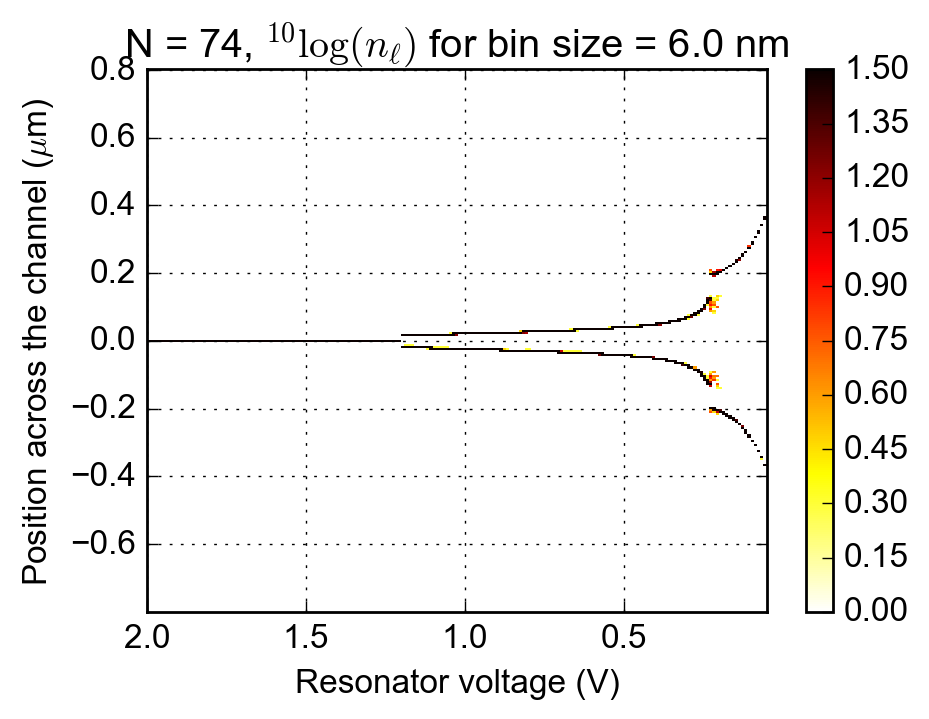

In [34]:
dbin = 0.006E-6
bins = np.arange(-0.80E-6, 0.80E-6+dbin, dbin)
#resonator_bounds = (7.87E-6, 27.84E-6)
#resonator_bounds = (7.87E-6, 47.84E-6)
resonator_bounds = (7.87E-6, 157.87E-6)
save = True

N_electrons = list()
noof_rows = np.zeros((196, len(sub_dirs)))

for N_axis, sub_dir in enumerate(sub_dirs):
    converged = list()
    energy = list()
    with h5py.File(os.path.join(os.path.join(save_path, sub_dir), "Results.h5"), "r") as f:
        print("Directory: %s" % sub_dir)
        k = 0
        for step in f.keys():
            if "step" in step:
                electron_ri = f[step + "/electron_final_coordinates"][()]
                xi, yi = anneal.r2xy(electron_ri)
                if k==0: 
                    print(len(xi))
                
                # Select only the electrons on the resonator.
                mask = np.logical_and(xi > resonator_bounds[0], xi < resonator_bounds[1])
                xi_resonator = xi[mask]
                yi_resonator = yi[mask]
                Xi, Yi = np.meshgrid(xi_resonator, yi_resonator)
                Xj, Yj = Xi.T, Yi.T
                
                if k == 0: 
                    Rij = np.sqrt((Xi-Xj)**2 + (Yi-Yj)**2)
                    Xij = np.abs(Xi-Xj)
                    np.fill_diagonal(Xij, 1000.)
                    np.fill_diagonal(Rij, 1000.)
                    mean_distance = np.mean(np.min(Rij, axis=0))
                    linear_density = np.mean(np.min(Xij, axis=0))
                    init_comparative_reselectrons = len(yi_resonator)*40E-6/(resonator_bounds[1]-resonator_bounds[0])
                    print("Linear density is %.3f um/electron"%(linear_density*1E6))
                    print("Mean distance of electrons on the resonator is %.3f um/electron"%(mean_distance*1E6))
                    print("Or this would correspond to %d electrons per 40 um"%(init_comparative_reselectrons))

                energy.append(f[step+"/energy"][()])
                valid_solution = f[step + "/solution_converged"][()]
                converged.append(valid_solution)

                if valid_solution:
                    electron_hist, bin_edges = np.histogram(yi_resonator, bins=bins)
                else:
                    electron_hist = np.zeros(len(electron_hist))

                if k == 0:
                    electron_histogram = electron_hist
                else:
                    electron_histogram = np.vstack((electron_histogram, electron_hist))

                k += 1
        
        N_elecs = np.sum(electron_histogram[0,:])
        N_electrons.append(N_elecs)
        N_threshold = 10
        num_peaks = list()
        for V_axis in range(np.shape(electron_histogram)[0]):
            peakind = np.where(electron_histogram[V_axis,:] > N_threshold)[0]
            peakind = np.delete(peakind, np.where(np.diff(peakind) == 1))
            num_peaks.append(len(peakind))
            noof_rows[V_axis, N_axis] = len(peakind)

        Vres = f["Vres"][()]
        xpoints = f["xpoints"][()]
        #potential = f["electrostatic_potential"][()]

    print("\tOut of %d simulations, %d did not converge..." % (len(Vres), len(Vres) - np.sum(converged)))

    fig = plt.figure(figsize=(5.,3.5))
    common.configure_axes(12)
    plt.pcolormesh(Vres, bins[:-1]*1E6, np.log10(electron_histogram.T), vmin=0, vmax=1.5, cmap=plt.cm.hot_r)
    plt.colorbar()
    plt.xlim(Vres[0], Vres[-1])
    plt.ylim(np.min(bins)*1E6, np.max(bins)*1E6)
    plt.xlabel("Resonator voltage (V)")
    plt.ylabel("Position across the channel ($\mu$m)")
    plt.title(r"N = %d, $^{10}\log (n_\ell)$ for bin size = %.1f nm"%(init_comparative_reselectrons, dbin*1E9))
    plt.grid()

    if save:
        common.save_figure(fig, os.path.join(save_path, sub_dir))